In [ ]:
!pip install optuna

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import torch.nn.functional as F
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split, SubsetRandomSampler
from torch import nn
import optuna
import torch.optim as Optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import plotly.express as px
import time

# Dataset

In [ ]:
data_dir = 'dataset'
transform = transforms.Compose(transforms=[transforms.ToTensor()])
td = torchvision.datasets.FashionMNIST(data_dir, download = True, train = True,transform = transform)
loader = torch.utils.data.DataLoader(td, batch_size = 64, shuffle = False)

### Mean and variance calculation

In [4]:
# calculation of mean and variance of the dataset to normalize the dataset for faster convergence
mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)
mean = mean.numpy()[0]
std = std.numpy()[0]
print(f" mean of the training dataset : {mean}")
print(f" std of the training dataset : {std}")

 mean of the training dataset : 0.2860407531261444
 std of the training dataset : 0.320453405380249


## Define the dataset

In [5]:
tr = transforms.Compose(transforms=[transforms.ToTensor() ,
                               transforms.Normalize((mean,), (std,))])
tr = transforms.Compose(transforms=[transforms.ToTensor()])
Train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True,transform = tr)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform = tr)

## Define the dataset transform

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(),])
test_transform = transforms.Compose([transforms.ToTensor(),])

## Define the dataloader

In [6]:
CompleteTrainLoader = DataLoader(Train_dataset, batch_size=256, shuffle=True)

In [7]:
train_dataset, val_dataset = random_split(Train_dataset, (50000, 10000))
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
# print(np.size(test_dataset))
# # print(iter(validation_dataloader).next()[1])
# i = iter(train_dataloader)
# b = next(i)
# print(b[1])

In [8]:
# ### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

In [ ]:
# kf = KFold(n_splits=2)
# print(kf.split(train_dataset))
# for i in kf.split(train_dataset):
#     print(i[1])

In [ ]:
# t = []
# for i,z in enumerate(train_dataset):
#     t.append(tuple([train_transform(z[0]),z[1]]))
# v = []
# for i,z in enumerate(val_dataset):
#     v.append(tuple([train_transform(z[0]),z[1]]))

## plot function

In [9]:
def PlotReconstructed(org,recon,epoch,figurHeight=8,figureWidth=5): 
    fig, axs = plt.subplots(1, 2, figsize=(figurHeight,figureWidth))
    axs[0].imshow(org.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(recon.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)

## AutoEncoder

Here we implemented two different Autoencoders.
The first on has **Three** convolutional layers and the seccond one has **four** convolutional layer in which the for the first convolutional layer the stride is one and since the kernel size is 3 the size of input image will not chenge(it will remain $28 \times 28$ after first layer).
Then we are going to tune the number of filters and in each layer, the optimizer and learning rate as hyper parameter using **Optuna** for both networks and choose the best one.

#### Autoencoder with three conv layers

In [10]:
class AE3class(nn.Module):
    
    def __init__(self, encoded_space_dim=2,NumFL1=16,NumFL2=32,NumFL3=64,latent=64):
#     def __init__(self, encoded_space_dim,NumFL1,NumFL2,NumFL3,latent):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=2, padding=1, output_padding=1)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x1 = self.encoder_lin(x)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(x1)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,x1

#### Autoencoder with four conv layers

In [11]:
class AE4class(nn.Module):
    
    def __init__(self, encoded_space_dim,NumFL1,NumFL2,NumFL3,NumFL4,latent):
        super().__init__()
        
        #----------------------Ecoder----------------------------------------------------
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 1, padding=1),#this layer does not change the image size
            nn.ReLU(True),
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),#output size = 
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            
            nn.Conv2d(in_channels=NumFL3, out_channels=NumFL4, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL4, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        #----------------------Decoder----------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=1, padding=1)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x1 = self.encoder_lin(x)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(x1)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,x1 #x1 is the endoced part and x is the reconstructed part

## Training function

In [12]:
### Training function
def train_epoch(encoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    TRloss = []
    encoder.train() 
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, Label in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data,_ = encoder(image_batch)

        loss = loss_fn(encoded_data, image_batch)
        TRloss.append(loss)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return TRloss
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

## Testing function

In [13]:
### Testing function
def test_epoch(encoder, device, dataloader, loss_fn):
    encoder.eval()
    batchValError = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data,_ = encoder(image_batch)
            
            conc_out.append(encoded_data.cpu())
            conc_label.append(image_batch.cpu())
            batchValError.append(loss_fn(encoded_data,image_batch).item())
        conc_out = torch.cat(conc_out)

        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data,batchValError

In [14]:
def trainingLoop(Epoch,Model,trainL,validL,LossFun,Optimizer,plotEachEpoch=True):
    lossEpochTrain = []
    lossEpochValidation = []
    for epoch in range(Epoch):
        print('EPOCH %d/%d' % (epoch + 1, Epoch))
        lossEpochTrain = lossEpochTrain + train_epoch(encoder= Model, device= device, 
                                                      dataloader= trainL, loss_fn= LossFun, 
                                                      optimizer= Optimizer)

        valloss,temp = test_epoch(encoder= Model, device= device, 
                                  dataloader= validL, loss_fn= LossFun)
        lossEpochValidation = lossEpochValidation + temp
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, Epoch, valloss))

        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        Model.eval()
        with torch.no_grad():
            rec_img,_  = Model(img)
        if plotEachEpoch:
            PlotReconstructed(org=img,recon=rec_img,epoch=epoch)
    final_val_loss,_ = test_epoch(encoder= Model, device= device, 
                                  dataloader= validL, loss_fn= LossFun)
    return lossEpochTrain,lossEpochValidation,final_val_loss
    # Plot the reconstructed image

In [ ]:
model = AE3class()
# print(model)

# *Comparing* **ADAM** and **Adamx** and **AdamW** optimizers
In this section we define a model with three convolutional layer(AE3class) with the default parameters defined in the model class and train the network for 10 epoch to compare the output.

In [15]:
device = "cpu"# "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.MSELoss()

In [ ]:
#Adam
epoch = 40
torch.manual_seed(0)
modelADAM = AE3class()
params_to_optimize = modelADAM.parameters()
optim = torch.optim.Adam(params_to_optimize, lr=0.005)

In [ ]:
Time = time.time()

trainErrorADAM,valErrorADAM,finalErrADAM = trainingLoop(Epoch=epoch,Model=modelADAM,
                                                        trainL=train_dataloader,
                                                        validL=validation_dataloader,
                                                        LossFun=loss_fn,Optimizer=optim,
                                                        plotEachEpoch=False)
print("the training time for {} epochs is {} minutes".format(epoch,(time.time()-Time)/60) )

EPOCH 1/40


	 VALIDATION - EPOCH 1/40 - loss: 0.034555


EPOCH 2/40


	 VALIDATION - EPOCH 2/40 - loss: 0.031284


EPOCH 3/40


	 VALIDATION - EPOCH 3/40 - loss: 0.032931


EPOCH 4/40


	 VALIDATION - EPOCH 4/40 - loss: 0.029472


EPOCH 5/40


	 VALIDATION - EPOCH 5/40 - loss: 0.028869


EPOCH 6/40


	 VALIDATION - EPOCH 6/40 - loss: 0.028417


EPOCH 7/40


	 VALIDATION - EPOCH 7/40 - loss: 0.027722


EPOCH 8/40


	 VALIDATION - EPOCH 8/40 - loss: 0.027413


EPOCH 9/40


	 VALIDATION - EPOCH 9/40 - loss: 0.027221


EPOCH 10/40


	 VALIDATION - EPOCH 10/40 - loss: 0.027296


EPOCH 11/40


	 VALIDATION - EPOCH 11/40 - loss: 0.026779


EPOCH 12/40


	 VALIDATION - EPOCH 12/40 - loss: 0.026839


EPOCH 13/40


	 VALIDATION - EPOCH 13/40 - loss: 0.026901


EPOCH 14/40


	 VALIDATION - EPOCH 14/40 - loss: 0.026597


EPOCH 15/40


	 VALIDATION - EPOCH 15/40 - loss: 0.026429


EPOCH 16/40


	 VALIDATION - EPOCH 16/40 - loss: 0.026250


EPOCH 17/40


	 VALIDATION - EPOCH 17/40 - loss: 0.026218


In [ ]:
#Adamx
modelAdamx = AE3class()
params_to_optimize = modelAdamx.parameters()
optim = torch.optim.Adamax(params_to_optimize, lr=0.005)

In [ ]:
Time = time.time()

trainErrorADAMx,valErrorADAMx,finalErrADAMx = trainingLoop(Epoch=epoch,Model=modelAdamx,
                                                        trainL=train_dataloader,
                                                        validL=validation_dataloader,
                                                        LossFun=loss_fn,Optimizer=optim,
                                                        plotEachEpoch=False)
print("the training time for {} epochs is {} minutes".format(epoch,(time.time()-Time)/60) )

EPOCH 1/40


	 VALIDATION - EPOCH 1/40 - loss: 0.037827


EPOCH 2/40


	 VALIDATION - EPOCH 2/40 - loss: 0.034104


EPOCH 3/40


	 VALIDATION - EPOCH 3/40 - loss: 0.032176


EPOCH 4/40


	 VALIDATION - EPOCH 4/40 - loss: 0.031272


EPOCH 5/40


	 VALIDATION - EPOCH 5/40 - loss: 0.030686


EPOCH 6/40


	 VALIDATION - EPOCH 6/40 - loss: 0.029796


EPOCH 7/40


	 VALIDATION - EPOCH 7/40 - loss: 0.029280


EPOCH 8/40


	 VALIDATION - EPOCH 8/40 - loss: 0.029202


EPOCH 9/40


	 VALIDATION - EPOCH 9/40 - loss: 0.028899


EPOCH 10/40


	 VALIDATION - EPOCH 10/40 - loss: 0.028606


EPOCH 11/40


	 VALIDATION - EPOCH 11/40 - loss: 0.028558


EPOCH 12/40


	 VALIDATION - EPOCH 12/40 - loss: 0.027961


EPOCH 13/40


	 VALIDATION - EPOCH 13/40 - loss: 0.027853


EPOCH 14/40


	 VALIDATION - EPOCH 14/40 - loss: 0.027824


EPOCH 15/40


	 VALIDATION - EPOCH 15/40 - loss: 0.027510


EPOCH 16/40


	 VALIDATION - EPOCH 16/40 - loss: 0.027564


EPOCH 17/40


	 VALIDATION - EPOCH 17/40 - loss: 0.027587


In [ ]:
#AdamW
torch.manual_seed(0)
modelAdamW = AE3class(encoded_space_dim = 2,NumFL1=16,NumFL2=32,NumFL3=64,latent=64)
params_to_optimize = modelAdamW.parameters()
optim = torch.optim.AdamW(params_to_optimize, lr=0.01)

In [ ]:
#AdamW

Time = time.time()
trainErrorAdamW,valErrorAdamW,finalErrAdamW = trainingLoop(Epoch=epoch,Model=modelAdamW,
                                                     trainL=train_dataloader,validL=validation_dataloader,
                                                     LossFun=loss_fn,Optimizer=optim,plotEachEpoch=False)
print("the training time for {} epochs is {} minutes".format(epoch,(time.time()-Time)/60) )

EPOCH 1/40


	 VALIDATION - EPOCH 1/40 - loss: 0.033118


EPOCH 2/40


	 VALIDATION - EPOCH 2/40 - loss: 0.031819


EPOCH 3/40


	 VALIDATION - EPOCH 3/40 - loss: 0.029988


EPOCH 4/40


	 VALIDATION - EPOCH 4/40 - loss: 0.029232


EPOCH 5/40


	 VALIDATION - EPOCH 5/40 - loss: 0.028732


EPOCH 6/40


	 VALIDATION - EPOCH 6/40 - loss: 0.028557


EPOCH 7/40


	 VALIDATION - EPOCH 7/40 - loss: 0.028742


EPOCH 8/40


	 VALIDATION - EPOCH 8/40 - loss: 0.028172


EPOCH 9/40


	 VALIDATION - EPOCH 9/40 - loss: 0.028162


EPOCH 10/40


	 VALIDATION - EPOCH 10/40 - loss: 0.027936


EPOCH 11/40


	 VALIDATION - EPOCH 11/40 - loss: 0.027488


EPOCH 12/40


	 VALIDATION - EPOCH 12/40 - loss: 0.027649


EPOCH 13/40


	 VALIDATION - EPOCH 13/40 - loss: 0.027790


EPOCH 14/40


	 VALIDATION - EPOCH 14/40 - loss: 0.027531


EPOCH 15/40


	 VALIDATION - EPOCH 15/40 - loss: 0.027140


EPOCH 16/40


	 VALIDATION - EPOCH 16/40 - loss: 0.027263


EPOCH 17/40


	 VALIDATION - EPOCH 17/40 - loss: 0.026918


In [ ]:
#Adagrad
torch.manual_seed(0)
modelAdagrad = AE3class(encoded_space_dim = 2,NumFL1=16,NumFL2=32,NumFL3=64,latent=64)
params_to_optimize = modelAdagrad.parameters()
optim = torch.optim.Adagrad(params_to_optimize, lr=0.005)

In [ ]:
#SGD

Time = time.time()
trainErrorAdagrad,valErrorAdagrad,finalErrAdagrad = trainingLoop(Epoch=epoch,Model=modelAdagrad,
                                                     trainL=train_dataloader,validL=validation_dataloader,
                                                     LossFun=loss_fn,Optimizer=optim,plotEachEpoch=False)
print("the training time for {} epochs is {} minutes".format(epoch,(time.time()-Time)/60) )

EPOCH 1/40


	 VALIDATION - EPOCH 1/40 - loss: 0.046308


EPOCH 2/40


	 VALIDATION - EPOCH 2/40 - loss: 0.040806


EPOCH 3/40


	 VALIDATION - EPOCH 3/40 - loss: 0.039194


EPOCH 4/40


	 VALIDATION - EPOCH 4/40 - loss: 0.037414


EPOCH 5/40


	 VALIDATION - EPOCH 5/40 - loss: 0.036883


EPOCH 6/40


	 VALIDATION - EPOCH 6/40 - loss: 0.035918


EPOCH 7/40


	 VALIDATION - EPOCH 7/40 - loss: 0.035139


EPOCH 8/40


	 VALIDATION - EPOCH 8/40 - loss: 0.034568


EPOCH 9/40


	 VALIDATION - EPOCH 9/40 - loss: 0.033910


EPOCH 10/40


	 VALIDATION - EPOCH 10/40 - loss: 0.033629


EPOCH 11/40


	 VALIDATION - EPOCH 11/40 - loss: 0.033075


EPOCH 12/40


	 VALIDATION - EPOCH 12/40 - loss: 0.032750


EPOCH 13/40


	 VALIDATION - EPOCH 13/40 - loss: 0.032325


EPOCH 14/40


	 VALIDATION - EPOCH 14/40 - loss: 0.032191


EPOCH 15/40


	 VALIDATION - EPOCH 15/40 - loss: 0.031777


EPOCH 16/40


	 VALIDATION - EPOCH 16/40 - loss: 0.031676


EPOCH 17/40


	 VALIDATION - EPOCH 17/40 - loss: 0.031446


In [ ]:
def TtoN(A):
    t = []
    for i in A:
        t.append(i.detach().numpy())
    return t

In [ ]:
# calculation running average of validation error
N = 40
MAvalErrorADAM = np.convolve(valErrorADAM, np.ones(N)/N, mode='valid')
MAvalErrorADAMx = np.convolve(valErrorADAMx, np.ones(N)/N, mode='valid')
MAvalErrorAdamW = np.convolve(valErrorAdamW, np.ones(N)/N, mode='valid')
MAvalErrorAdagrad = np.convolve(valErrorAdagrad, np.ones(N)/N, mode='valid')

Text(0.5, 0, 'Epoch')

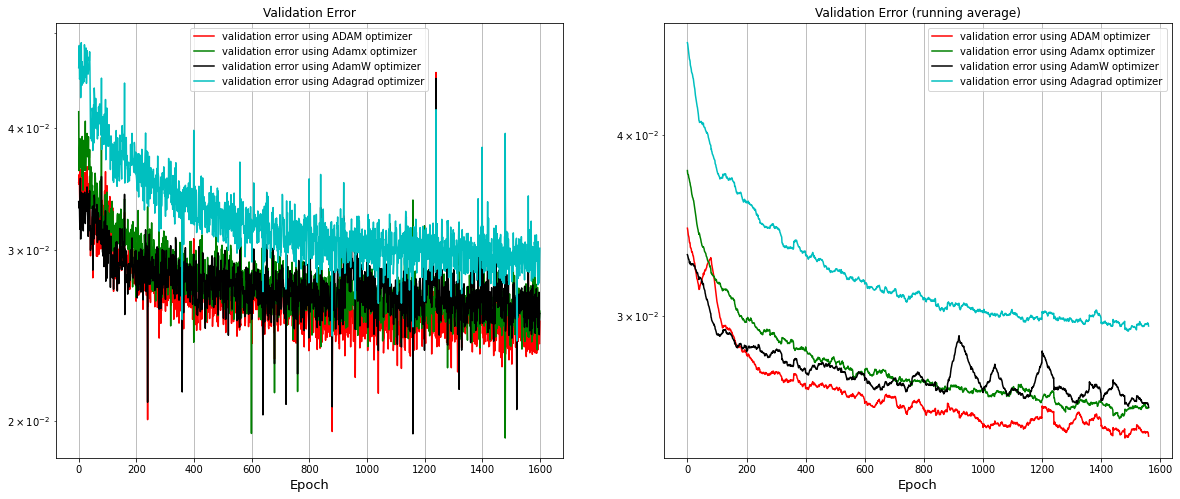

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(20)
ax[0].semilogy(range(len(valErrorADAM)),valErrorADAM,c='r',label="validation error using ADAM optimizer")
ax[0].semilogy(range(len(valErrorADAMx)),valErrorADAMx,c='g',label="validation error using Adamx optimizer")
ax[0].semilogy(range(len(valErrorAdamW)),valErrorAdamW,c='k',label="validation error using AdamW optimizer")
ax[0].semilogy(range(len(valErrorAdagrad)),valErrorAdagrad,c='c',label="validation error using Adagrad optimizer")
leg = ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Validation Error')
ax[0].set_xlabel('Epoch', fontsize=13)

ax[1].semilogy(range(len(MAvalErrorADAM)),MAvalErrorADAM,c='r',label="validation error using ADAM optimizer")
ax[1].semilogy(range(len(MAvalErrorADAMx)),MAvalErrorADAMx,c='g',label="validation error using Adamx optimizer")
ax[1].semilogy(range(len(MAvalErrorAdamW)),MAvalErrorAdamW,c='k',label="validation error using AdamW optimizer")
ax[1].semilogy(range(len(MAvalErrorAdagrad)),MAvalErrorAdagrad,c='c',label="validation error using Adagrad optimizer")
leg = ax[1].legend()
ax[1].grid(True)
ax[1].set_title('Validation Error (running average)')
ax[1].set_xlabel('Epoch', fontsize=13)

In [ ]:
adam = TtoN(trainErrorADAM)
adamx = TtoN(trainErrorADAMx)
adamW = TtoN(trainErrorAdamW)
adagrad = TtoN(trainErrorAdagrad)

In [ ]:
# calculation running average of training error
N = 40
moving_averages_adam = np.convolve(adam, np.ones(N)/N, mode='valid')
moving_averages_adamx = np.convolve(adamx, np.ones(N)/N, mode='valid')
moving_averages_adamw = np.convolve(adamW, np.ones(N)/N, mode='valid')
moving_averages_adagrad = np.convolve(adagrad, np.ones(N)/N, mode='valid')

Text(0.5, 0, 'Epoch')

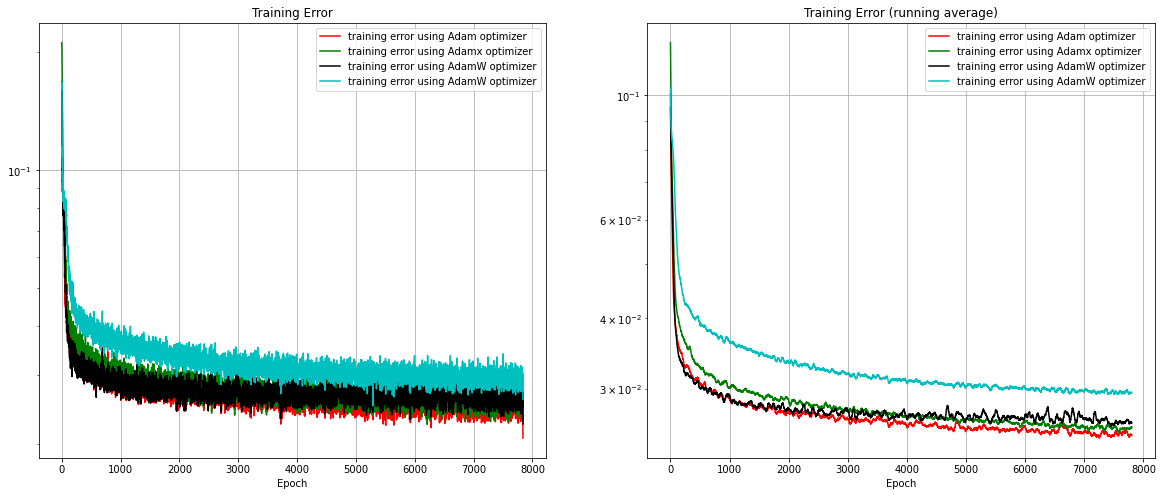

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(8)
fig.set_figwidth(20)
ax[0].semilogy(range(len(adam)),adam,c='r',label="training error using Adam optimizer")
ax[0].semilogy(range(len(adamx)),adamx,c='g',label="training error using Adamx optimizer")
ax[0].semilogy(range(len(adamW)),adamW,c='k',label="training error using AdamW optimizer")
ax[0].semilogy(range(len(adagrad)),adagrad,c='c',label="training error using AdamW optimizer")
leg = ax[0].legend()
ax[0].grid(True)
ax[0].set_title('Training Error')
ax[0].set_xlabel('Epoch')

ax[1].semilogy(range(len(moving_averages_adam)),moving_averages_adam,c='r',label="training error using Adam optimizer")
ax[1].semilogy(range(len(moving_averages_adamx)),moving_averages_adamx,c='g',label="training error using Adamx optimizer")
ax[1].semilogy(range(len(moving_averages_adamw)),moving_averages_adamw,c='k',label="training error using AdamW optimizer")
ax[1].semilogy(range(len(moving_averages_adagrad)),moving_averages_adagrad,c='c',label="training error using AdamW optimizer")
leg = ax[1].legend()
ax[1].grid(True)
ax[1].set_title('Training Error (running average)')
ax[1].set_xlabel('Epoch')

## Optuna
In this part we define the objective function that we are going to optimize using optuna.
**Note** that I tried training the network using SGD optimizer but the output loss was usually higher than using Adam. Therefor, for better results and less computation time I decided to use only Adam and RAdam as optimizers.
Another parameter that could be used as hyperparameter is **kernel** **size** but because the size of input image is small, using kernel size with size of 5 or 3 will not make much difference so I used fixed kernel size(kenel_size = 3).

### optuna for network with three conv layers

In [ ]:
loss_fn = torch.nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
def obj(trial):
    cfg = { 
          'n_epochs' : 15,
          'lr' : trial.suggest_loguniform('lr', 1e-4, 5e-2),
          'optimizer': trial.suggest_categorical('optimizer',["RAdam","Adam"]),
          'activation': F.relu,
          'space_dim': 2, #trial.suggest_discrete_uniform('space_dim',2,3,1),
          'NumF1':trial.suggest_discrete_uniform('NumF1',8,16,4),
          'NumF2':trial.suggest_discrete_uniform('NumF2',16,32,8),
          'NumF3':trial.suggest_discrete_uniform('NumF3',32,64,16),
          'latent_layer':trial.suggest_discrete_uniform('latent_layer',64,128,32),
          }

    torch.manual_seed(42)
    model = AE3class(int(cfg['space_dim']),int(cfg['NumF1']),int(cfg['NumF2']),int(cfg['NumF3']),int(cfg['latent_layer'])).to(device)
    # if torch.cuda.is_available():
    #     model.cuda()
    optimizer = getattr(Optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
    print("")
    for epoch in range(1, cfg['n_epochs'] + 1):
        train_epoch(encoder=model,device=cfg['device'],
                    dataloader=train_dataloader,loss_fn=loss_fn,
                    optimizer=optimizer)
    val_loss,_ = test_epoch(encoder=model,device=device, 
                            dataloader=validation_dataloader, 
                            loss_fn=loss_fn)
    return val_loss

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="minimize")
study.optimize(obj, n_trials=100, timeout=60000)

[I 2022-03-12 17:03:34,648] A new study created in memory with name: no-name-4fb1bbfd-4d7e-4ab7-bbe8-ba91e5276dc6


[I 2022-03-12 17:05:34,943] Trial 0 finished with value: 0.029745429754257202 and parameters: {'lr': 0.017122789326575145, 'optimizer': 'Adam', 'NumF1': 8.0, 'NumF2': 16.0, 'NumF3': 32.0, 'latent_layer': 64.0}. Best is trial 0 with value: 0.029745429754257202.


[I 2022-03-12 17:07:35,050] Trial 1 finished with value: 0.02896132878959179 and parameters: {'lr': 0.0010808785570023958, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 64.0, 'latent_layer': 64.0}. Best is trial 1 with value: 0.02896132878959179.


[I 2022-03-12 17:09:34,653] Trial 2 finished with value: 0.030401017516851425 and parameters: {'lr': 0.00036966853631732754, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'latent_layer': 96.0}. Best is trial 1 with value: 0.02896132878959179.


[I 2022-03-12 17:11:34,720] Trial 3 finished with value: 0.028997663408517838 and parameters: {'lr': 0.027976023051293236, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 32.0, 'latent_layer': 64.0}. Best is trial 1 with value: 0.02896132878959179.


[I 2022-03-12 17:13:34,432] Trial 4 finished with value: 0.030752131715416908 and parameters: {'lr': 0.023365866894249618, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 32.0, 'latent_layer': 128.0}. Best is trial 1 with value: 0.02896132878959179.


[I 2022-03-12 17:15:33,582] Trial 5 finished with value: 0.031207749620079994 and parameters: {'lr': 0.0002677529201396388, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 48.0, 'latent_layer': 96.0}. Best is trial 1 with value: 0.02896132878959179.


[I 2022-03-12 17:17:33,103] Trial 6 finished with value: 0.028808211907744408 and parameters: {'lr': 0.0008214554338162418, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 64.0, 'latent_layer': 96.0}. Best is trial 6 with value: 0.028808211907744408.


[I 2022-03-12 17:19:39,928] Trial 7 finished with value: 0.028239162638783455 and parameters: {'lr': 0.002364267100228427, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'latent_layer': 64.0}. Best is trial 7 with value: 0.028239162638783455.


[I 2022-03-12 17:21:43,586] Trial 8 finished with value: 0.03402470797300339 and parameters: {'lr': 0.00012171732031059748, 'optimizer': 'Adam', 'NumF1': 16.0, 'NumF2': 32.0, 'NumF3': 64.0, 'latent_layer': 96.0}. Best is trial 7 with value: 0.028239162638783455.


[I 2022-03-12 17:23:51,929] Trial 9 finished with value: 0.027857482433319092 and parameters: {'lr': 0.016323795077491564, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 32.0, 'NumF3': 32.0, 'latent_layer': 64.0}. Best is trial 9 with value: 0.027857482433319092.


[I 2022-03-12 17:25:59,528] Trial 10 finished with value: 0.02777297981083393 and parameters: {'lr': 0.0042700562462445815, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 10 with value: 0.02777297981083393.


[I 2022-03-12 17:28:05,996] Trial 11 finished with value: 0.0274435356259346 and parameters: {'lr': 0.005370870440069995, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 11 with value: 0.0274435356259346.


[I 2022-03-12 17:30:11,117] Trial 12 finished with value: 0.026972221210598946 and parameters: {'lr': 0.00511992143757795, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:32:16,411] Trial 13 finished with value: 0.027692249044775963 and parameters: {'lr': 0.004935541115441761, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:34:21,478] Trial 14 finished with value: 0.028035730123519897 and parameters: {'lr': 0.007200044605328775, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:36:26,429] Trial 15 finished with value: 0.02838628739118576 and parameters: {'lr': 0.008893134278097745, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:38:31,234] Trial 16 finished with value: 0.02818932570517063 and parameters: {'lr': 0.0021027253010913304, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:40:36,453] Trial 17 finished with value: 0.029281482100486755 and parameters: {'lr': 0.04286586163965629, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:42:42,408] Trial 18 finished with value: 0.02817496843636036 and parameters: {'lr': 0.001775332017170416, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 96.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:44:48,434] Trial 19 finished with value: 0.0294149462133646 and parameters: {'lr': 0.01051140816470571, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 16.0, 'NumF3': 32.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:46:52,934] Trial 20 finished with value: 0.02719693072140217 and parameters: {'lr': 0.003764937805459981, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 12 with value: 0.026972221210598946.


[I 2022-03-12 17:48:57,955] Trial 21 finished with value: 0.026958325877785683 and parameters: {'lr': 0.004021469353722158, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 17:51:02,729] Trial 22 finished with value: 0.027573682367801666 and parameters: {'lr': 0.0030964040034262424, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 17:53:07,923] Trial 23 finished with value: 0.029033100232481956 and parameters: {'lr': 0.0011018469980971556, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 96.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 17:55:13,564] Trial 24 finished with value: 0.02735746093094349 and parameters: {'lr': 0.0029127297924296017, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 17:57:19,594] Trial 25 finished with value: 0.02835526131093502 and parameters: {'lr': 0.011308745626265673, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 16.0, 'NumF3': 32.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 17:59:26,165] Trial 26 finished with value: 0.028854919597506523 and parameters: {'lr': 0.0013840303423056767, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'latent_layer': 96.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:01:32,226] Trial 27 finished with value: 0.027092834934592247 and parameters: {'lr': 0.003934783792677847, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:03:37,624] Trial 28 finished with value: 0.0319644920527935 and parameters: {'lr': 0.0005872927461020727, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:05:42,922] Trial 29 finished with value: 0.027799397706985474 and parameters: {'lr': 0.006372866250435936, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 16.0, 'NumF3': 32.0, 'latent_layer': 96.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:07:48,028] Trial 30 finished with value: 0.027060002088546753 and parameters: {'lr': 0.014379256528869238, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:09:51,903] Trial 31 finished with value: 0.027575332671403885 and parameters: {'lr': 0.014843594979683192, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:11:56,166] Trial 32 finished with value: 0.027585193514823914 and parameters: {'lr': 0.007486264784083494, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:14:00,282] Trial 33 finished with value: 0.0289100781083107 and parameters: {'lr': 0.02929825249795039, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:16:04,376] Trial 34 finished with value: 0.02729414775967598 and parameters: {'lr': 0.012363245164335897, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:18:03,929] Trial 35 finished with value: 0.028436120599508286 and parameters: {'lr': 0.02388446703045648, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:20:08,516] Trial 36 finished with value: 0.027915174141526222 and parameters: {'lr': 0.003711935446542289, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 32.0, 'latent_layer': 96.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:22:08,675] Trial 37 finished with value: 0.027472510933876038 and parameters: {'lr': 0.0017047551877176434, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:24:13,675] Trial 38 finished with value: 0.031005050987005234 and parameters: {'lr': 0.04872809583499574, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 96.0}. Best is trial 21 with value: 0.026958325877785683.


[I 2022-03-12 18:26:13,695] Trial 39 finished with value: 0.02685736119747162 and parameters: {'lr': 0.002703778824232402, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:28:13,625] Trial 40 finished with value: 0.029658176004886627 and parameters: {'lr': 0.0005383135988458165, 'optimizer': 'Adam', 'NumF1': 8.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 64.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:30:13,972] Trial 41 finished with value: 0.026926778256893158 and parameters: {'lr': 0.002386397730152316, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:32:14,035] Trial 42 finished with value: 0.027086272835731506 and parameters: {'lr': 0.002684677272613286, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:34:13,892] Trial 43 finished with value: 0.027890410274267197 and parameters: {'lr': 0.0011403026085876659, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:36:15,015] Trial 44 finished with value: 0.027436653152108192 and parameters: {'lr': 0.005772923601931779, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:38:14,734] Trial 45 finished with value: 0.027681227773427963 and parameters: {'lr': 0.0019738423170382125, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 64.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:40:15,791] Trial 46 finished with value: 0.028108010068535805 and parameters: {'lr': 0.020034503672116493, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:42:15,452] Trial 47 finished with value: 0.02866934798657894 and parameters: {'lr': 0.0007062041196973092, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:44:16,985] Trial 48 finished with value: 0.03242465481162071 and parameters: {'lr': 0.00018612189727834814, 'optimizer': 'Adam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:46:17,686] Trial 49 finished with value: 0.027934234589338303 and parameters: {'lr': 0.008261948447233972, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 32.0, 'latent_layer': 96.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:48:15,560] Trial 50 finished with value: 0.027583463117480278 and parameters: {'lr': 0.001418269105156109, 'optimizer': 'Adam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:50:14,610] Trial 51 finished with value: 0.027041412889957428 and parameters: {'lr': 0.002687314295508118, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 39 with value: 0.02685736119747162.


[I 2022-03-12 18:52:12,821] Trial 52 finished with value: 0.02666637673974037 and parameters: {'lr': 0.004663195806931985, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 52 with value: 0.02666637673974037.


[I 2022-03-12 18:54:11,063] Trial 53 finished with value: 0.026841074228286743 and parameters: {'lr': 0.0046726552320158566, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 52 with value: 0.02666637673974037.


[I 2022-03-12 18:56:09,176] Trial 54 finished with value: 0.026451189070940018 and parameters: {'lr': 0.004748478691420016, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 18:58:06,807] Trial 55 finished with value: 0.02705279365181923 and parameters: {'lr': 0.004684504293305534, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:00:04,843] Trial 56 finished with value: 0.02766837552189827 and parameters: {'lr': 0.0031926663668910434, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:02:06,323] Trial 57 finished with value: 0.02673432044684887 and parameters: {'lr': 0.0022551334595055316, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:04:05,055] Trial 58 finished with value: 0.027468232437968254 and parameters: {'lr': 0.002281268581358727, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:06:05,998] Trial 59 finished with value: 0.028304573148489 and parameters: {'lr': 0.0015581253657846819, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:08:04,740] Trial 60 finished with value: 0.027515757828950882 and parameters: {'lr': 0.005865470621448381, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:10:04,175] Trial 61 finished with value: 0.02706916071474552 and parameters: {'lr': 0.0034841212066083435, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:12:03,864] Trial 62 finished with value: 0.026715751737356186 and parameters: {'lr': 0.004723376659148623, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:14:02,500] Trial 63 finished with value: 0.026705026626586914 and parameters: {'lr': 0.004644612440276188, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:16:01,133] Trial 64 finished with value: 0.027662979438900948 and parameters: {'lr': 0.009272514429355304, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:18:00,005] Trial 65 finished with value: 0.027112338691949844 and parameters: {'lr': 0.004678209121672963, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:19:58,729] Trial 66 finished with value: 0.02691005729138851 and parameters: {'lr': 0.00677572930094329, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:21:56,880] Trial 67 finished with value: 0.026573559269309044 and parameters: {'lr': 0.005253783735974956, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:23:55,558] Trial 68 finished with value: 0.027906427159905434 and parameters: {'lr': 0.005003375231000556, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 64.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:25:54,048] Trial 69 finished with value: 0.027280321344733238 and parameters: {'lr': 0.009870835535994084, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:27:52,242] Trial 70 finished with value: 0.027186058461666107 and parameters: {'lr': 0.004251099055707734, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:29:49,834] Trial 71 finished with value: 0.027216557413339615 and parameters: {'lr': 0.0030168170413083025, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:31:47,906] Trial 72 finished with value: 0.027485303580760956 and parameters: {'lr': 0.007781873142895732, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:33:45,990] Trial 73 finished with value: 0.026983918622136116 and parameters: {'lr': 0.005870194334483384, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:35:44,096] Trial 74 finished with value: 0.027188275009393692 and parameters: {'lr': 0.00200417350112917, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:37:42,793] Trial 75 finished with value: 0.026976652443408966 and parameters: {'lr': 0.003712682678814969, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:39:42,939] Trial 76 finished with value: 0.02727193757891655 and parameters: {'lr': 0.006880204582955577, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:41:41,702] Trial 77 finished with value: 0.027143407613039017 and parameters: {'lr': 0.004275761939714652, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:43:40,359] Trial 78 finished with value: 0.027346068993210793 and parameters: {'lr': 0.0024913303970967443, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 96.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:45:40,092] Trial 79 finished with value: 0.027623426169157028 and parameters: {'lr': 0.012243848124876375, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:47:38,600] Trial 80 finished with value: 0.027089618146419525 and parameters: {'lr': 0.00320048024983972, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:49:39,877] Trial 81 finished with value: 0.026858951896429062 and parameters: {'lr': 0.006597179248051627, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:51:39,134] Trial 82 finished with value: 0.027153240516781807 and parameters: {'lr': 0.005150564853608934, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:53:38,332] Trial 83 finished with value: 0.0266213808208704 and parameters: {'lr': 0.005418353247012273, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:55:36,107] Trial 84 finished with value: 0.026710625737905502 and parameters: {'lr': 0.004116074408604084, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:57:33,202] Trial 85 finished with value: 0.026989435777068138 and parameters: {'lr': 0.005370566401804351, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 19:59:31,559] Trial 86 finished with value: 0.027157917618751526 and parameters: {'lr': 0.008505318925858247, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:01:33,789] Trial 87 finished with value: 0.02668493054807186 and parameters: {'lr': 0.004152449930973066, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:03:34,753] Trial 88 finished with value: 0.027052434161305428 and parameters: {'lr': 0.003414104596495753, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:05:35,576] Trial 89 finished with value: 0.026847952976822853 and parameters: {'lr': 0.003975590405400723, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:07:36,215] Trial 90 finished with value: 0.027825739234685898 and parameters: {'lr': 0.005969060548322667, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:09:36,299] Trial 91 finished with value: 0.02675633691251278 and parameters: {'lr': 0.004453019858782386, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:11:36,890] Trial 92 finished with value: 0.02693507820367813 and parameters: {'lr': 0.004277508050155859, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:13:35,403] Trial 93 finished with value: 0.026883477345108986 and parameters: {'lr': 0.0072411606693278405, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:15:34,126] Trial 94 finished with value: 0.02703847736120224 and parameters: {'lr': 0.0037366883735590463, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:17:32,144] Trial 95 finished with value: 0.03527456894516945 and parameters: {'lr': 0.00010122867563357547, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:19:29,781] Trial 96 finished with value: 0.02717330865561962 and parameters: {'lr': 0.005350171947445703, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:21:27,886] Trial 97 finished with value: 0.027157066389918327 and parameters: {'lr': 0.0027826854513158194, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:23:25,889] Trial 98 finished with value: 0.026706935837864876 and parameters: {'lr': 0.0033065116348486314, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}. Best is trial 54 with value: 0.026451189070940018.


[I 2022-03-12 20:25:24,188] Trial 99 finished with value: 0.027698542922735214 and parameters: {'lr': 0.002165182038932538, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 96.0}. Best is trial 54 with value: 0.026451189070940018.


In [ ]:
print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

  Number of finished trials:  100
Best trial:
  Value:  0.026451189070940018


### optuna for network with four conv layers

In [ ]:
def obj(trial):
    cfg = { 
          'n_epochs' : 15,
          'lr' : trial.suggest_loguniform('lr', 1e-4, 5e-2),
          'optimizer': trial.suggest_categorical('optimizer',["RAdam","Adam"]),
          'activation': F.relu,
          'space_dim': 2, #trial.suggest_discrete_uniform('space_dim',2,3,1),
          'NumF1':trial.suggest_discrete_uniform('NumF1',8,16,4),
          'NumF2':trial.suggest_discrete_uniform('NumF2',16,32,8),
          'NumF3':trial.suggest_discrete_uniform('NumF3',32,64,16),
          'NumF4':trial.suggest_discrete_uniform('NumF4',32,128,16),
          'latent_layer':trial.suggest_discrete_uniform('latent_layer',64,128,32),
          }

    torch.manual_seed(42)
    model = AE4class(int(cfg['space_dim']),int(cfg['NumF1']),int(cfg['NumF2']),int(cfg['NumF3']),int(cfg['NumF4']),int(cfg['latent_layer'])).to(device)
    # if torch.cuda.is_available():
    #     model.cuda()
    optimizer = getattr(Optim, cfg['optimizer'])(model.parameters(), lr=cfg['lr'])
    print("")
    for epoch in range(1, cfg['n_epochs'] + 1):
        train_epoch(encoder=model,device=device,
                    dataloader=train_dataloader,loss_fn=loss_fn,
                    optimizer=optimizer)
    val_loss,_ = test_epoch(encoder=model,device=device, 
                            dataloader=validation_dataloader, 
                            loss_fn=loss_fn)
    return val_loss

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(),direction="minimize")
study.optimize(obj, n_trials=120, timeout=60000)

[I 2022-03-12 21:18:19,273] A new study created in memory with name: no-name-75eafbef-845c-4b48-a906-4586d5014da0


[I 2022-03-12 21:19:34,171] Trial 0 finished with value: 0.028993338346481323 and parameters: {'lr': 0.02696308276605054, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 24.0, 'NumF3': 32.0, 'NumF4': 32.0, 'latent_layer': 64.0}. Best is trial 0 with value: 0.028993338346481323.


[I 2022-03-12 21:20:47,953] Trial 1 finished with value: 0.028542298823595047 and parameters: {'lr': 0.021368598407684913, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 32.0, 'NumF3': 48.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 1 with value: 0.028542298823595047.


[I 2022-03-12 21:22:01,505] Trial 2 finished with value: 0.02849576249718666 and parameters: {'lr': 0.003895346545958745, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 128.0, 'latent_layer': 64.0}. Best is trial 2 with value: 0.02849576249718666.


[I 2022-03-12 21:23:14,463] Trial 3 finished with value: 0.03011140413582325 and parameters: {'lr': 0.0007174862985231431, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 16.0, 'NumF3': 32.0, 'NumF4': 48.0, 'latent_layer': 64.0}. Best is trial 2 with value: 0.02849576249718666.


[I 2022-03-12 21:24:25,903] Trial 4 finished with value: 0.027146711945533752 and parameters: {'lr': 0.001949590384107221, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 32.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:25:37,407] Trial 5 finished with value: 0.027148300781846046 and parameters: {'lr': 0.006194474831616235, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 64.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:26:49,416] Trial 6 finished with value: 0.03495650365948677 and parameters: {'lr': 0.00011599913225703716, 'optimizer': 'Adam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 48.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:28:04,271] Trial 7 finished with value: 0.03422502055764198 and parameters: {'lr': 0.0002277517110101689, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 32.0, 'NumF3': 48.0, 'NumF4': 112.0, 'latent_layer': 64.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:29:15,473] Trial 8 finished with value: 0.027753682807087898 and parameters: {'lr': 0.009157087595650705, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 48.0, 'NumF4': 32.0, 'latent_layer': 128.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:30:26,474] Trial 9 finished with value: 0.03093942068517208 and parameters: {'lr': 0.03152828745767539, 'optimizer': 'Adam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 32.0, 'NumF4': 32.0, 'latent_layer': 64.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:31:36,077] Trial 10 finished with value: 0.029556099325418472 and parameters: {'lr': 0.0011124284395929004, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 96.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:32:45,491] Trial 11 finished with value: 0.02800283022224903 and parameters: {'lr': 0.003348223589188809, 'optimizer': 'Adam', 'NumF1': 8.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 96.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:33:53,533] Trial 12 finished with value: 0.027673393487930298 and parameters: {'lr': 0.007143952822616705, 'optimizer': 'Adam', 'NumF1': 8.0, 'NumF2': 16.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 96.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:35:07,082] Trial 13 finished with value: 0.028348585590720177 and parameters: {'lr': 0.0012620103113620928, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 32.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:36:20,902] Trial 14 finished with value: 0.03195270895957947 and parameters: {'lr': 0.00047023141860289507, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 96.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:37:32,123] Trial 15 finished with value: 0.02810823544859886 and parameters: {'lr': 0.008716163506463174, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 32.0, 'NumF4': 64.0, 'latent_layer': 96.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:38:45,561] Trial 16 finished with value: 0.027379054576158524 and parameters: {'lr': 0.0023064477910580868, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:39:55,983] Trial 17 finished with value: 0.030461477115750313 and parameters: {'lr': 0.005260503843805002, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 48.0, 'NumF4': 64.0, 'latent_layer': 96.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:41:05,794] Trial 18 finished with value: 0.02830038033425808 and parameters: {'lr': 0.012488071387403179, 'optimizer': 'Adam', 'NumF1': 8.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 112.0, 'latent_layer': 64.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:42:20,445] Trial 19 finished with value: 0.027671802788972855 and parameters: {'lr': 0.001686813720919028, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 32.0, 'NumF4': 48.0, 'latent_layer': 128.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:43:30,551] Trial 20 finished with value: 0.030603714287281036 and parameters: {'lr': 0.0003833097062756367, 'optimizer': 'Adam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 4 with value: 0.027146711945533752.


[I 2022-03-12 21:44:43,605] Trial 21 finished with value: 0.027070732787251472 and parameters: {'lr': 0.0025361270782246572, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.027070732787251472.


[I 2022-03-12 21:45:56,683] Trial 22 finished with value: 0.027083968743681908 and parameters: {'lr': 0.002645631795942581, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.027070732787251472.


[I 2022-03-12 21:47:09,599] Trial 23 finished with value: 0.02817891165614128 and parameters: {'lr': 0.0023764063774927976, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.027070732787251472.


[I 2022-03-12 21:48:22,965] Trial 24 finished with value: 0.030577518045902252 and parameters: {'lr': 0.0008030312252015687, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.027070732787251472.


[I 2022-03-12 21:49:36,555] Trial 25 finished with value: 0.03169628232717514 and parameters: {'lr': 0.0036307481169703536, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 48.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 21 with value: 0.027070732787251472.


[I 2022-03-12 21:50:50,655] Trial 26 finished with value: 0.026791740208864212 and parameters: {'lr': 0.0019449225354960871, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 21:52:05,748] Trial 27 finished with value: 0.030100980773568153 and parameters: {'lr': 0.000859122955914922, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 21:53:19,928] Trial 28 finished with value: 0.02707374468445778 and parameters: {'lr': 0.015819985784604924, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 21:54:34,124] Trial 29 finished with value: 0.03114384599030018 and parameters: {'lr': 0.04264805048407528, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 21:55:48,490] Trial 30 finished with value: 0.030397698283195496 and parameters: {'lr': 0.01768010063299509, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 48.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 21:57:02,427] Trial 31 finished with value: 0.02747337892651558 and parameters: {'lr': 0.014430572113480328, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 21:58:15,846] Trial 32 finished with value: 0.027196737006306648 and parameters: {'lr': 0.00294313290350591, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 21:59:29,715] Trial 33 finished with value: 0.02753409557044506 and parameters: {'lr': 0.0050141022834007945, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 22:00:42,903] Trial 34 finished with value: 0.027777384966611862 and parameters: {'lr': 0.0015500873065500574, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 22:01:55,800] Trial 35 finished with value: 0.027563821524381638 and parameters: {'lr': 0.02372695574224677, 'optimizer': 'RAdam', 'NumF1': 8.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 22:03:09,250] Trial 36 finished with value: 0.026881791651248932 and parameters: {'lr': 0.004802446289674141, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 22:04:23,047] Trial 37 finished with value: 0.02738933265209198 and parameters: {'lr': 0.009725024219938929, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 32.0, 'NumF3': 48.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 26 with value: 0.026791740208864212.


[I 2022-03-12 22:05:35,918] Trial 38 finished with value: 0.026621399447321892 and parameters: {'lr': 0.005169291186424193, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 38 with value: 0.026621399447321892.


[I 2022-03-12 22:06:49,234] Trial 39 finished with value: 0.028701001778244972 and parameters: {'lr': 0.004442733742893037, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 48.0, 'latent_layer': 96.0}. Best is trial 38 with value: 0.026621399447321892.


[I 2022-03-12 22:08:00,640] Trial 40 finished with value: 0.027226708829402924 and parameters: {'lr': 0.004017210134883712, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 38 with value: 0.026621399447321892.


[I 2022-03-12 22:09:11,863] Trial 41 finished with value: 0.0265344250947237 and parameters: {'lr': 0.0073432950881811045, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:10:23,832] Trial 42 finished with value: 0.027127014473080635 and parameters: {'lr': 0.00677905286360387, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:11:35,260] Trial 43 finished with value: 0.026782598346471786 and parameters: {'lr': 0.01099899611629216, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:12:45,878] Trial 44 finished with value: 0.02709423191845417 and parameters: {'lr': 0.010686181773542667, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:13:56,851] Trial 45 finished with value: 0.027109595015645027 and parameters: {'lr': 0.007027147818152771, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:15:07,752] Trial 46 finished with value: 0.0271721463650465 and parameters: {'lr': 0.005483359877569615, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:16:19,142] Trial 47 finished with value: 0.029303550720214844 and parameters: {'lr': 0.008353850231036965, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 48.0, 'NumF4': 64.0, 'latent_layer': 96.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:17:30,435] Trial 48 finished with value: 0.03143687918782234 and parameters: {'lr': 0.031394031323339566, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 48.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:18:41,499] Trial 49 finished with value: 0.03570413589477539 and parameters: {'lr': 0.00010024298969682385, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 96.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:19:51,797] Trial 50 finished with value: 0.02876025065779686 and parameters: {'lr': 0.018745417592093614, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:21:05,452] Trial 51 finished with value: 0.027858149260282516 and parameters: {'lr': 0.003608441709977979, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:22:16,964] Trial 52 finished with value: 0.02735064923763275 and parameters: {'lr': 0.0019955788250190904, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:23:28,184] Trial 53 finished with value: 0.027798328548669815 and parameters: {'lr': 0.0015710411217742114, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:24:39,605] Trial 54 finished with value: 0.026685170829296112 and parameters: {'lr': 0.0029383748634506483, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 41 with value: 0.0265344250947237.


[I 2022-03-12 22:25:51,003] Trial 55 finished with value: 0.0264193806797266 and parameters: {'lr': 0.011389013147508117, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 55 with value: 0.0264193806797266.


[I 2022-03-12 22:27:02,189] Trial 56 finished with value: 0.02709897607564926 and parameters: {'lr': 0.012197948253943549, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 55 with value: 0.0264193806797266.


[I 2022-03-12 22:28:10,404] Trial 57 finished with value: 0.028635583817958832 and parameters: {'lr': 0.0011553505107272483, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 55 with value: 0.0264193806797266.


[I 2022-03-12 22:29:21,554] Trial 58 finished with value: 0.026192283257842064 and parameters: {'lr': 0.008451354437419867, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:30:32,617] Trial 59 finished with value: 0.026549868285655975 and parameters: {'lr': 0.008139183403645462, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:31:40,742] Trial 60 finished with value: 0.027641596272587776 and parameters: {'lr': 0.008058421311980127, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:32:51,797] Trial 61 finished with value: 0.02765430137515068 and parameters: {'lr': 0.011882082308429355, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 128.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:34:02,884] Trial 62 finished with value: 0.026881475001573563 and parameters: {'lr': 0.006904930839172641, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:35:14,198] Trial 63 finished with value: 0.027204500511288643 and parameters: {'lr': 0.005922255184111305, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:36:25,452] Trial 64 finished with value: 0.02709641307592392 and parameters: {'lr': 0.01488313118518649, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 128.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:37:36,536] Trial 65 finished with value: 0.027918588370084763 and parameters: {'lr': 0.009766702717605111, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:38:47,687] Trial 66 finished with value: 0.028206631541252136 and parameters: {'lr': 0.02180546997891792, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 64.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:39:58,903] Trial 67 finished with value: 0.026951445266604424 and parameters: {'lr': 0.0031537793278796026, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:41:10,187] Trial 68 finished with value: 0.02791786566376686 and parameters: {'lr': 0.005980650961140877, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 128.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:42:21,628] Trial 69 finished with value: 0.028033625334501266 and parameters: {'lr': 0.013334912114821467, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 32.0, 'NumF4': 96.0, 'latent_layer': 64.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:43:29,799] Trial 70 finished with value: 0.027354268357157707 and parameters: {'lr': 0.004289627928600064, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:44:41,016] Trial 71 finished with value: 0.026902586221694946 and parameters: {'lr': 0.008891803803111787, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:45:52,493] Trial 72 finished with value: 0.028120631352066994 and parameters: {'lr': 0.0020686040259690654, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 32.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:47:04,899] Trial 73 finished with value: 0.02785228192806244 and parameters: {'lr': 0.002860879164175809, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:48:16,095] Trial 74 finished with value: 0.02634688839316368 and parameters: {'lr': 0.00794430234467434, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:49:27,194] Trial 75 finished with value: 0.02658497728407383 and parameters: {'lr': 0.010570622940520247, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:50:38,415] Trial 76 finished with value: 0.02708655595779419 and parameters: {'lr': 0.007624870989661625, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:51:49,781] Trial 77 finished with value: 0.02732689119875431 and parameters: {'lr': 0.019026931325413214, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:53:00,889] Trial 78 finished with value: 0.032435037195682526 and parameters: {'lr': 0.00021543198708345943, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:54:12,373] Trial 79 finished with value: 0.02665262669324875 and parameters: {'lr': 0.0059882473111483245, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:55:24,231] Trial 80 finished with value: 0.02797752432525158 and parameters: {'lr': 0.016121759081522018, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:56:36,064] Trial 81 finished with value: 0.027602432295680046 and parameters: {'lr': 0.005228767923369128, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:57:47,517] Trial 82 finished with value: 0.027369068935513496 and parameters: {'lr': 0.006281715474797447, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 22:58:59,077] Trial 83 finished with value: 0.027665819972753525 and parameters: {'lr': 0.009427372579975328, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:00:10,254] Trial 84 finished with value: 0.026292365044355392 and parameters: {'lr': 0.0045787925222147575, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:01:21,492] Trial 85 finished with value: 0.027152620255947113 and parameters: {'lr': 0.007868807522206502, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:02:33,176] Trial 86 finished with value: 0.027388887479901314 and parameters: {'lr': 0.01092972594497267, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:03:44,383] Trial 87 finished with value: 0.027147145941853523 and parameters: {'lr': 0.004791865782760011, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:04:53,003] Trial 88 finished with value: 0.028345227241516113 and parameters: {'lr': 0.004085802806390101, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:06:06,326] Trial 89 finished with value: 0.0273339431732893 and parameters: {'lr': 0.006602617150831284, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:07:19,746] Trial 90 finished with value: 0.02666502073407173 and parameters: {'lr': 0.013302608711623549, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:08:33,121] Trial 91 finished with value: 0.027532940730452538 and parameters: {'lr': 0.010176697901753361, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:09:46,458] Trial 92 finished with value: 0.027444664388895035 and parameters: {'lr': 0.01433039551111603, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:11:00,209] Trial 93 finished with value: 0.027086526155471802 and parameters: {'lr': 0.012261293694152917, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:12:14,113] Trial 94 finished with value: 0.033169109374284744 and parameters: {'lr': 0.02598055030654269, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:13:28,257] Trial 95 finished with value: 0.027132369577884674 and parameters: {'lr': 0.0086416193325543, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 32.0, 'NumF4': 128.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:14:41,519] Trial 96 finished with value: 0.027852529659867287 and parameters: {'lr': 0.005868588117038131, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'NumF4': 112.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:15:52,998] Trial 97 finished with value: 0.026650166139006615 and parameters: {'lr': 0.0035578005862576963, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:17:04,804] Trial 98 finished with value: 0.02681805193424225 and parameters: {'lr': 0.004800549311777923, 'optimizer': 'RAdam', 'NumF1': 16.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:18:16,607] Trial 99 finished with value: 0.027311956509947777 and parameters: {'lr': 0.0035657941103386585, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:19:28,100] Trial 100 finished with value: 0.026848098263144493 and parameters: {'lr': 0.007099285967248473, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:20:39,983] Trial 101 finished with value: 0.02679203450679779 and parameters: {'lr': 0.00769640420830655, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 96.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:21:51,207] Trial 102 finished with value: 0.026535531505942345 and parameters: {'lr': 0.005389446087460106, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:23:02,727] Trial 103 finished with value: 0.026339201256632805 and parameters: {'lr': 0.005487423348621457, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:24:14,158] Trial 104 finished with value: 0.026580864563584328 and parameters: {'lr': 0.003767120256740178, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:25:25,356] Trial 105 finished with value: 0.02669205702841282 and parameters: {'lr': 0.005462705049239881, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:26:33,973] Trial 106 finished with value: 0.027040613815188408 and parameters: {'lr': 0.004256328598653737, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:27:45,671] Trial 107 finished with value: 0.027773238718509674 and parameters: {'lr': 0.008742978447945303, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:28:57,145] Trial 108 finished with value: 0.027897413820028305 and parameters: {'lr': 0.00468082770350328, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:30:07,842] Trial 109 finished with value: 0.02720162272453308 and parameters: {'lr': 0.002481382285184525, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 16.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:31:19,392] Trial 110 finished with value: 0.026826821267604828 and parameters: {'lr': 0.011160673295868015, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:32:30,891] Trial 111 finished with value: 0.02663986198604107 and parameters: {'lr': 0.003842401233374872, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:33:42,475] Trial 112 finished with value: 0.02667154185473919 and parameters: {'lr': 0.0031334604343864017, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:34:54,473] Trial 113 finished with value: 0.027133669704198837 and parameters: {'lr': 0.005398946629607991, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 64.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:36:07,792] Trial 114 finished with value: 0.026653291657567024 and parameters: {'lr': 0.003788635817691744, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:37:21,035] Trial 115 finished with value: 0.026581887155771255 and parameters: {'lr': 0.007213124276696447, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:38:34,165] Trial 116 finished with value: 0.02661190554499626 and parameters: {'lr': 0.006773790320103118, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:39:47,054] Trial 117 finished with value: 0.026494517922401428 and parameters: {'lr': 0.007150981447669456, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:41:00,153] Trial 118 finished with value: 0.026555269956588745 and parameters: {'lr': 0.009393731502688999, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 128.0}. Best is trial 58 with value: 0.026192283257842064.


[I 2022-03-12 23:42:13,594] Trial 119 finished with value: 0.026834653690457344 and parameters: {'lr': 0.007437437550993576, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 80.0, 'latent_layer': 96.0}. Best is trial 58 with value: 0.026192283257842064.


## k-fold cross validation

In [ ]:
def Mean(k):
    z = []
    for i in k:
        z.append(i.detach().numpy())
    return sum(z)/len(z)

In [80]:
loss_fn = torch.nn.MSELoss()
# device = "cuda" if torch.cuda.is_available() else "cpu"
# bestParams =  {'lr': 0.008451354437419867, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}

k = 5 # number of folds
kfold = KFold(n_splits=k, shuffle=True)
kfoldErrors = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(Train_dataset)):
    
    # Print
    print(f'FOLD {fold}')
    print('------------------------------------------')
    torch.manual_seed(42)
    kfmodel = AE3class(encoded_space_dim=2,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer'])).to(device)
    params_to_optimize = kfmodel.parameters()
    optim = torch.optim.Adam(params_to_optimize, lr=bestParams['lr'], weight_decay=1e-5)
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(Train_dataset,batch_size=256, 
                                              sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(Train_dataset,batch_size=256, 
                                             sampler=test_subsampler)
    
    tre,vale,f = trainingLoop(Epoch=1,Model=kfmodel,
                            trainL=train_dataloader,
                            validL=validation_dataloader,LossFun=loss_fn,
                            Optimizer=optim,plotEachEpoch=False)
    kfoldErrors.append(f)


FOLD 0
------------------------------------------
EPOCH 1/1


	 VALIDATION - EPOCH 1/1 - loss: 0.034989


FOLD 1
------------------------------------------
EPOCH 1/1


	 VALIDATION - EPOCH 1/1 - loss: 0.034060


FOLD 2
------------------------------------------
EPOCH 1/1


	 VALIDATION - EPOCH 1/1 - loss: 0.033988


FOLD 3
------------------------------------------
EPOCH 1/1


	 VALIDATION - EPOCH 1/1 - loss: 0.034071


FOLD 4
------------------------------------------
EPOCH 1/1


	 VALIDATION - EPOCH 1/1 - loss: 0.035260




In [81]:
print("The k-fold cross validation loss is:",np.mean(kfoldErrors))

The k-fold cross validation loss is: 0.034473486


# Training the network with best parameters
### Initialize the network with best parameters.

In [41]:

bestParams = {'lr': 0.004748478691420016, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}
ModelAE =AE3class(2,int(bestParams['NumF1']),int(bestParams['NumF2']),
                  int(bestParams['NumF3']),int(bestParams['latent_layer'])).to(device)

In [42]:
loss_fn = torch.nn.MSELoss()
lr = bestParams['lr'] # Learning rate
params_to_optimize = ModelAE.parameters() 
optim = torch.optim.Adam(params_to_optimize, lr=lr)

### Training loop

EPOCH 1/30


	 VALIDATION - EPOCH 1/30 - loss: 0.033117




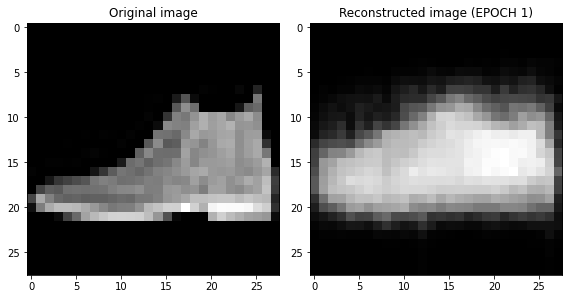

EPOCH 2/30


	 VALIDATION - EPOCH 2/30 - loss: 0.030739




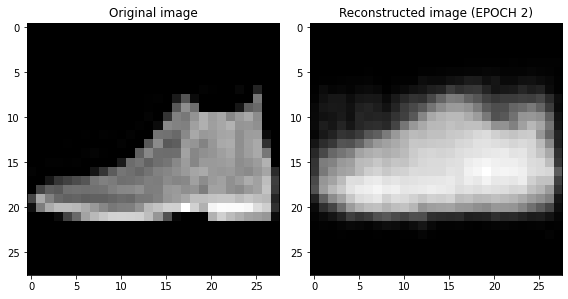

EPOCH 3/30


	 VALIDATION - EPOCH 3/30 - loss: 0.029433




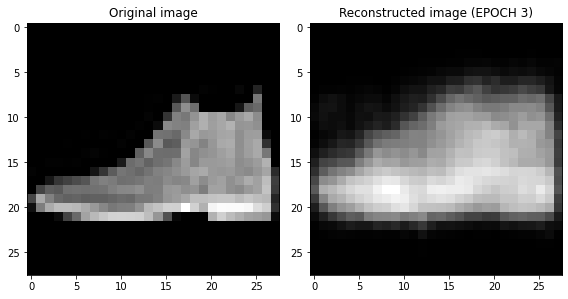

EPOCH 4/30


	 VALIDATION - EPOCH 4/30 - loss: 0.029196




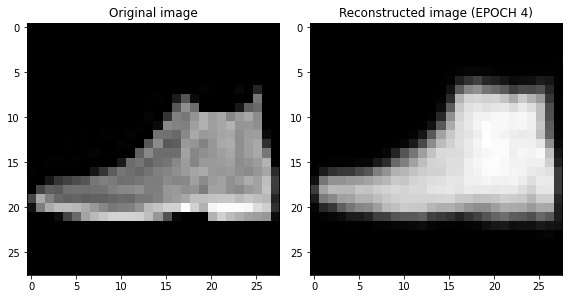

EPOCH 5/30


	 VALIDATION - EPOCH 5/30 - loss: 0.029038




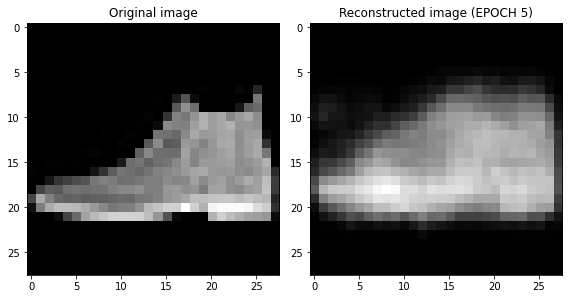

EPOCH 6/30


	 VALIDATION - EPOCH 6/30 - loss: 0.028166




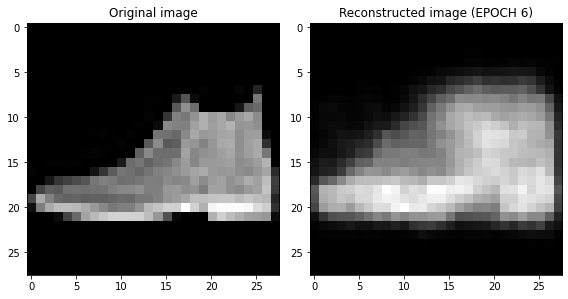

EPOCH 7/30


	 VALIDATION - EPOCH 7/30 - loss: 0.028054




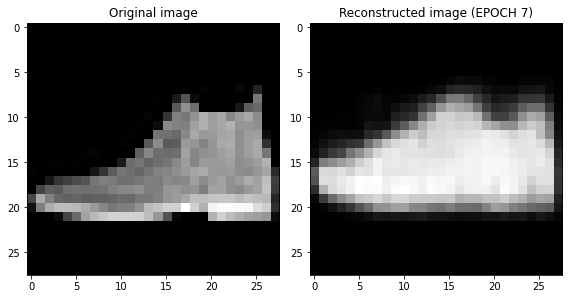

EPOCH 8/30


	 VALIDATION - EPOCH 8/30 - loss: 0.028046




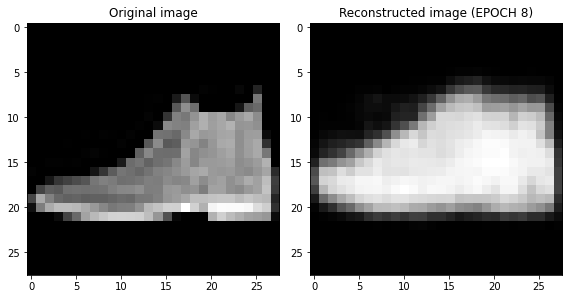

EPOCH 9/30


	 VALIDATION - EPOCH 9/30 - loss: 0.027754




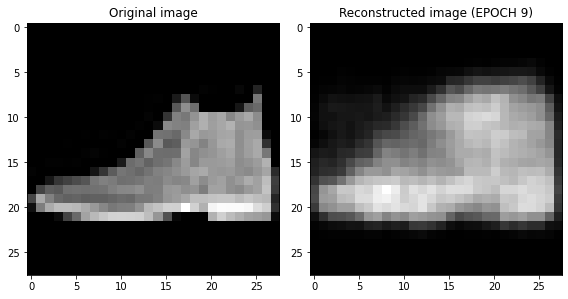

EPOCH 10/30


	 VALIDATION - EPOCH 10/30 - loss: 0.027509




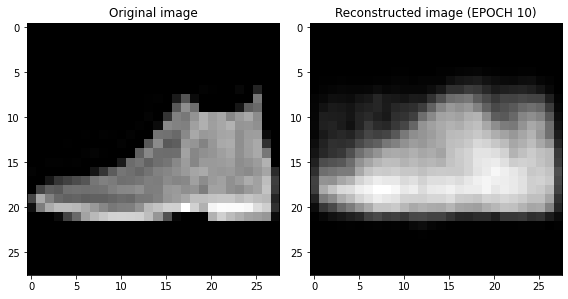

EPOCH 11/30


	 VALIDATION - EPOCH 11/30 - loss: 0.027244




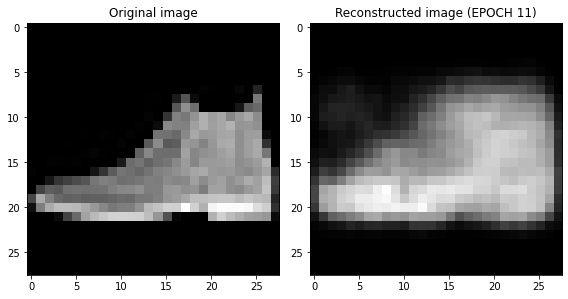

EPOCH 12/30


	 VALIDATION - EPOCH 12/30 - loss: 0.027912




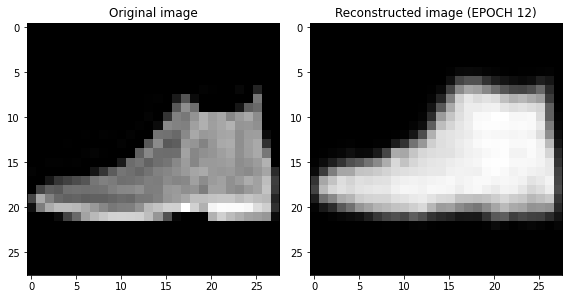

EPOCH 13/30


	 VALIDATION - EPOCH 13/30 - loss: 0.026961




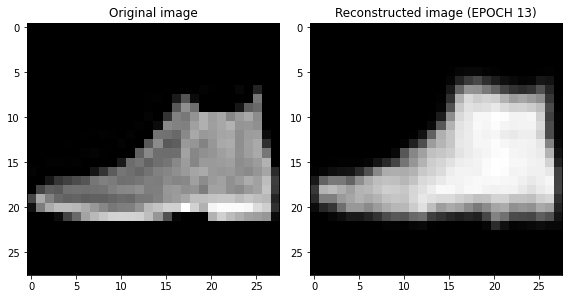

EPOCH 14/30


	 VALIDATION - EPOCH 14/30 - loss: 0.027004




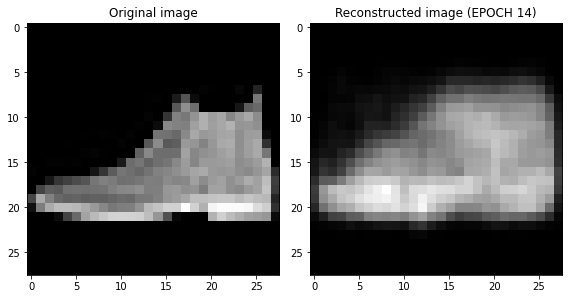

EPOCH 15/30


	 VALIDATION - EPOCH 15/30 - loss: 0.027093




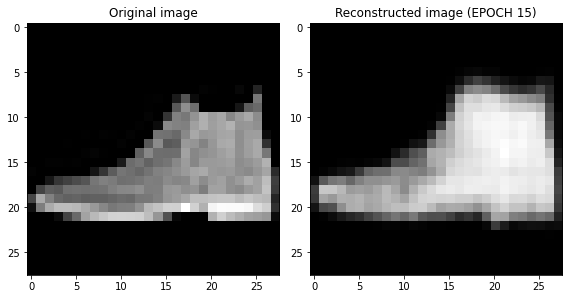

EPOCH 16/30


	 VALIDATION - EPOCH 16/30 - loss: 0.027072




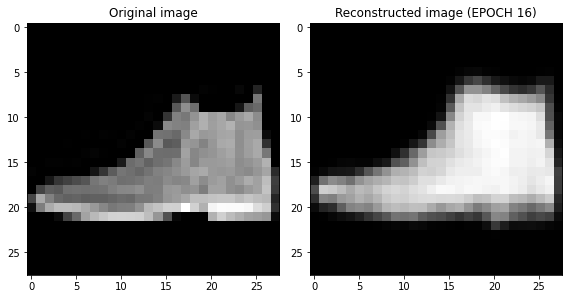

EPOCH 17/30


	 VALIDATION - EPOCH 17/30 - loss: 0.026365




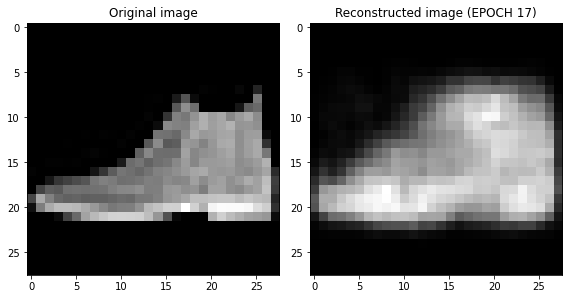

EPOCH 18/30


	 VALIDATION - EPOCH 18/30 - loss: 0.030362




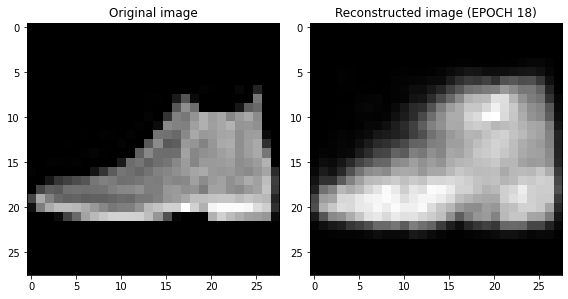

EPOCH 19/30


	 VALIDATION - EPOCH 19/30 - loss: 0.027742




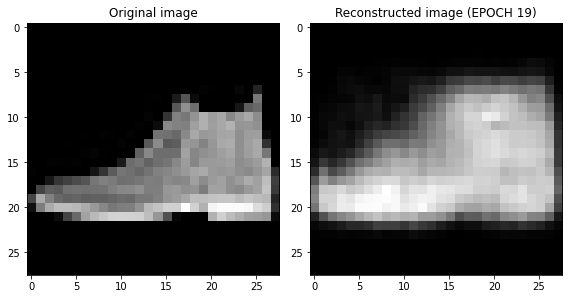

EPOCH 20/30


	 VALIDATION - EPOCH 20/30 - loss: 0.027108




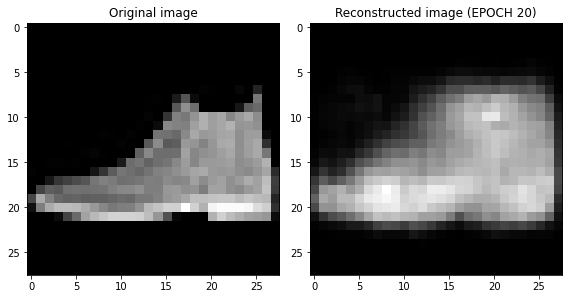

EPOCH 21/30


	 VALIDATION - EPOCH 21/30 - loss: 0.026677




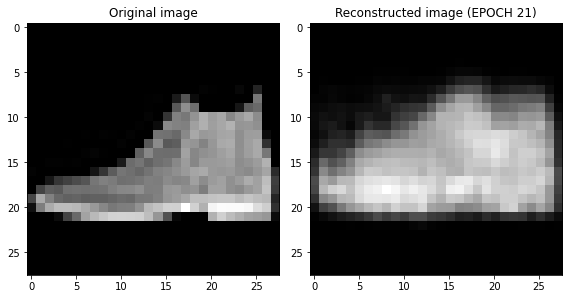

EPOCH 22/30


	 VALIDATION - EPOCH 22/30 - loss: 0.026177




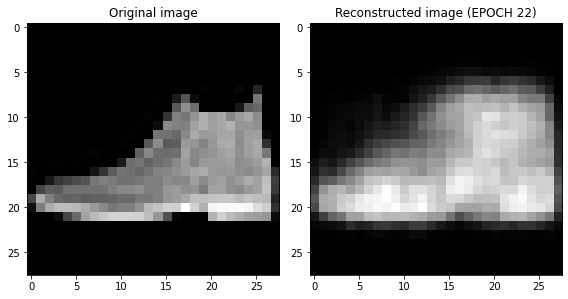

EPOCH 23/30


	 VALIDATION - EPOCH 23/30 - loss: 0.026470




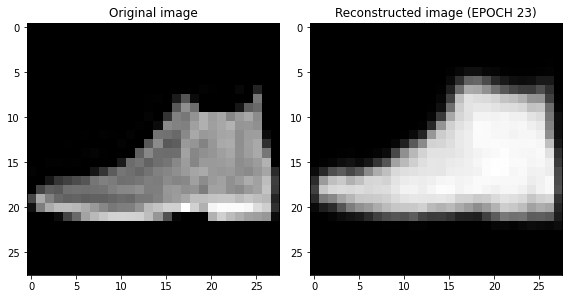

EPOCH 24/30


	 VALIDATION - EPOCH 24/30 - loss: 0.026323




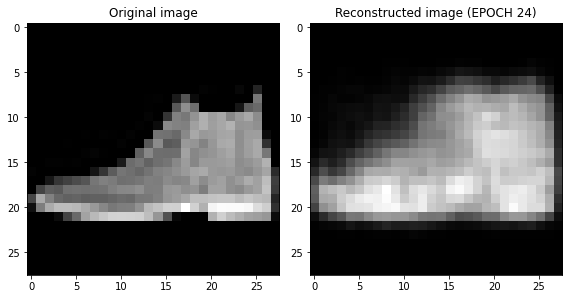

EPOCH 25/30


	 VALIDATION - EPOCH 25/30 - loss: 0.026642




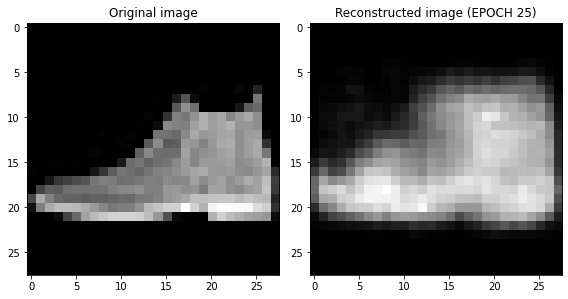

EPOCH 26/30


	 VALIDATION - EPOCH 26/30 - loss: 0.026150




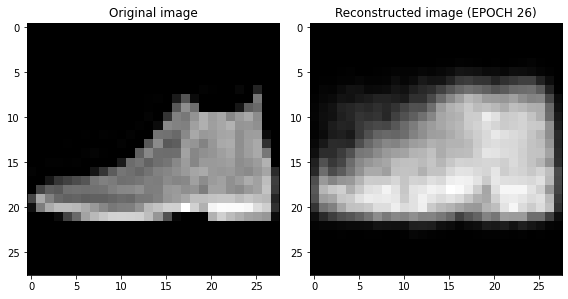

EPOCH 27/30


	 VALIDATION - EPOCH 27/30 - loss: 0.026135




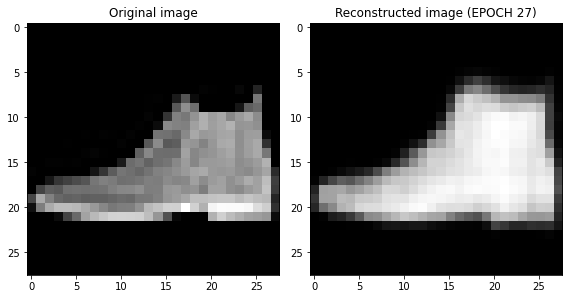

EPOCH 28/30


	 VALIDATION - EPOCH 28/30 - loss: 0.027730




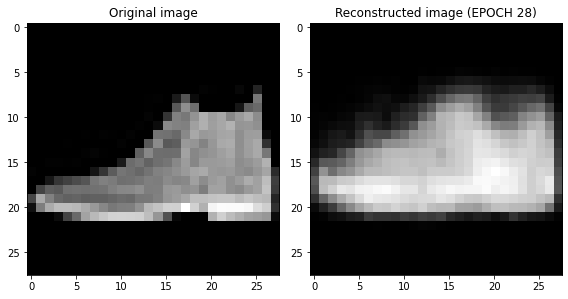

EPOCH 29/30


	 VALIDATION - EPOCH 29/30 - loss: 0.026434




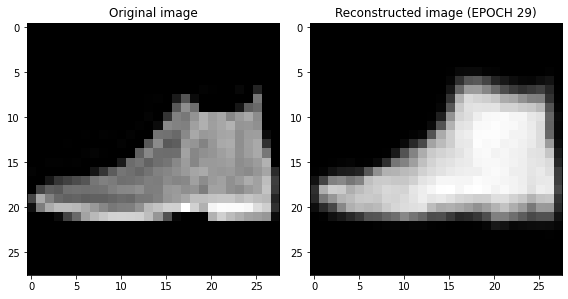

EPOCH 30/30


	 VALIDATION - EPOCH 30/30 - loss: 0.026303




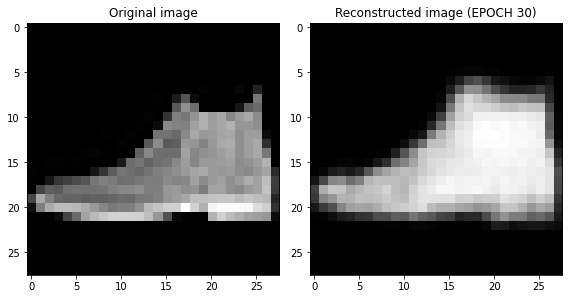

In [43]:
tre,vale,finalerr = trainingLoop(Epoch=30,Model=ModelAE,
                                 trainL=CompleteTrainLoader,
                                 validL=test_dataloader,
                                 LossFun=loss_fn,Optimizer=optim)

In [82]:
PATH = "bestmodel.pth"
torch.save(ModelAE.state_dict(), PATH)

# Fine tuning for classification task 
firt we load the model we obtained after optuning
Then by adding a fully connected layer of ten nuerons we define a new network and retrain it for the task of classification.

In [85]:
Loss_fn = nn.CrossEntropyLoss()

In [88]:
 
bestParams = {'lr': 0.004748478691420016, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}
loadedM =AE3class(2,int(bestParams['NumF1']),int(bestParams['NumF2']),
                  int(bestParams['NumF3']),int(bestParams['latent_layer'])).to(device)
loadedM.load_state_dict(torch.load(PATH))
print(loadedM)

AE3class(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=432, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=432, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(48, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(24, 12, kerne

In [116]:
def accuracy(a,b):
    acc = 0
    length = len(a)
    blen = len(b)
    if length == blen:
        for index,i in enumerate(a):
            if i == b[index]:
                acc = acc + 1
    else:
        print('lists are not of the same length')
    return acc/length

In [100]:
class finetune(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayer = (ModelAE.encoder_cnn)
        self.fc = (ModelAE.encoder_lin[0:1])
        self.flatten = nn.Flatten(start_dim=1)
        self.out = nn.Linear(in_features=128,out_features=10)
    def forward(self, x):
        # Apply convolutions
        x = self.convlayer(x)
        # Flatten
        x = self.flatten(x)
        x = self.fc(x)
        x = self.out(x)
        return x

In [126]:
fineTunModel = finetune().to(device)
params_to_optimize = fineTunModel.parameters()
optim = torch.optim.Adam(params_to_optimize, lr=0.005)

In [127]:
### Training function
def Train_epoch(encoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    TRloss = []
    encoder.train() 
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, Label in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        Label = Label.to(device)
        # Encode data
        output = encoder(image_batch)
        loss = loss_fn(output, Label)
        TRloss.append(loss)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return TRloss
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

In [128]:
### Testing function
def Test_epoch(encoder, device, dataloader, loss_fn):
    encoder.eval()
    batchValError = []
    acc = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, Label in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            Label = Label.to(device)
            # Encode data
            output = encoder(image_batch)
            
            conc_out.append(output.cpu())
            conc_label.append(Label.cpu())
            batchValError.append(loss_fn(output,Label).item())
            acc.append(accuracy(output.argmax(dim=1),Label))
        conc_out = torch.cat(conc_out)

        conc_label = torch.cat(conc_label)
        
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data,batchValError,acc

In [129]:
Epoch = 10
training_loss = []
validation_error = []
Accuracy = []
currentTime = time.time()
for epoch in range(Epoch):
    training_loss.append(Train_epoch(encoder=fineTunModel,
                        device =device ,
                        dataloader=train_dataloader,
                        loss_fn=Loss_fn,
                        optimizer=optim))
    _,temp,temp2 = Test_epoch(encoder=fineTunModel,device=device,
                        dataloader=validation_dataloader,
                        loss_fn=Loss_fn)
    Accuracy.append(temp2)
    validation_error.append(temp)
    print(sum(temp2)/len(temp2))
print("-------------------")
print("training time for {} epochs is:{} minutes".format(Epoch,(time.time()-currentTime)/60))
print("-------------------")

0.8447265625
0.85322265625
0.88125
0.88388671875
0.8947265625
0.89462890625
0.89287109375
0.89736328125
0.8998046875
0.89716796875
-------------------
training time for 10 epochs is:1.55137327114741 minutes
-------------------


main label : 2
predicted label :  2


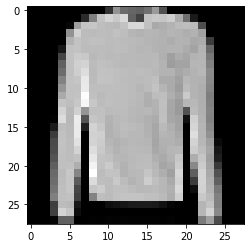

In [135]:
data_iter = iter(validation_dataloader)
im , label = data_iter.next()
image = im[0]
print("main label :",label[0].detach().numpy())
plt.imshow(image.squeeze(),cmap='gray')
l = fineTunModel(image.unsqueeze(dim=1).to(device)).cpu().detach().numpy()[0]
print("predicted label : ",l.argmax())

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [ ]:
! pip install plotly==5.5.0

In [45]:
# Load network parameters
# bestParams =  {'lr': 0.008451354437419867, 'optimizer': 'RAdam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 64.0, 'NumF4': 112.0, 'latent_layer': 96.0}
# torch.manual_seed(42)
# loadedM =AE4class(2,int(bestParams['NumF1']),int(bestParams['NumF2']),
#                   int(bestParams['NumF3']),int(bestParams['NumF4']),int(bestParams['latent_layer'])).to(device)
# loadedM.load_state_dict(torch.load(PATH))


bestParams = {'lr': 0.004748478691420016, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}
loadedM =AE3class(2,int(bestParams['NumF1']),int(bestParams['NumF2']),
                  int(bestParams['NumF3']),int(bestParams['latent_layer'])).to(device)
loadedM.load_state_dict(torch.load(PATH))


<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [46]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    loadedM.eval()
    with torch.no_grad():
        _,encoded_img  = loadedM(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:10<00:00, 911.46it/s]


In [47]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
# encoded_samples

This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [48]:
px.scatter(encoded_samples,x='Enc. Variable 0', y='Enc. Variable 1',
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

### performing pca and t-sne on 2D latent space

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
# encoded_samples_reduced_PCA
encoded_samples_pca = pd.DataFrame(encoded_samples_reduced_PCA)
px.scatter(encoded_samples_pca,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

In [51]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_PCA = tsne.fit_transform(encoded_samples)
# encoded_samples_reduced_PCA
encoded_samples_tsne = pd.DataFrame(encoded_samples_reduced_PCA)
px.scatter(encoded_samples_tsne,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



As you can see from the graph, even if we never used the labels (i.e. the id of the class in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

## Extracting the generator part of the Autoencoder
since we defined both the encoder and decoder(generator) parts in one single class here for generating new samples from latent space we need to have the encoder seperately.

In [52]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder_lin = (loadedM.decoder_lin)
        self.unflatten = (loadedM.unflatten)
        self.decoder_conv = loadedM.decoder_conv
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

In [53]:
Generator = generator()

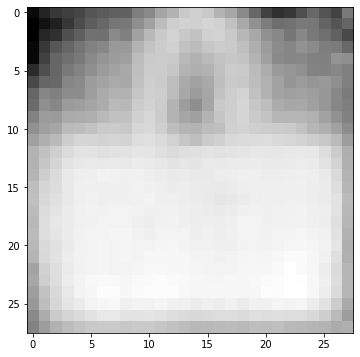

In [62]:
# if encoded_space_dim == 2:
# Generate a custom sample
custom_encoded_sample = [17, -20]
custom_encoded_sample = [-3, -2]
encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

# Decode sample
Generator.eval()
with torch.no_grad():
    generated_img  = Generator(encoded_value)

plt.figure(figsize=(8,6))
plt.imshow(generated_img.squeeze().cpu().numpy(),cmap='gray')
plt.show()

# Further insights on PCA and t-SNE

Let's do the same training again, with encoded dimension equal to 10.

### training AE with laten size of 10

Selected device: cuda
EPOCH 1/9


	 VALIDATION - EPOCH 1/9 - loss: 0.024057




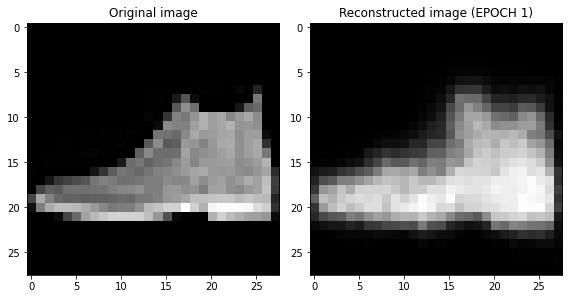

EPOCH 2/9


	 VALIDATION - EPOCH 2/9 - loss: 0.020163




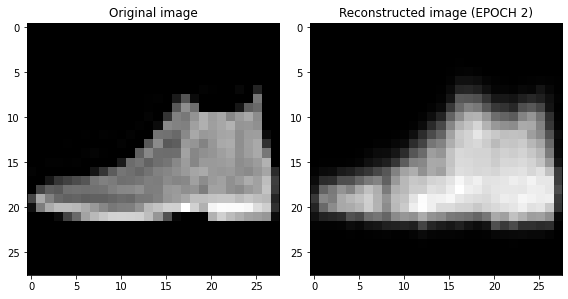

EPOCH 3/9


	 VALIDATION - EPOCH 3/9 - loss: 0.018443




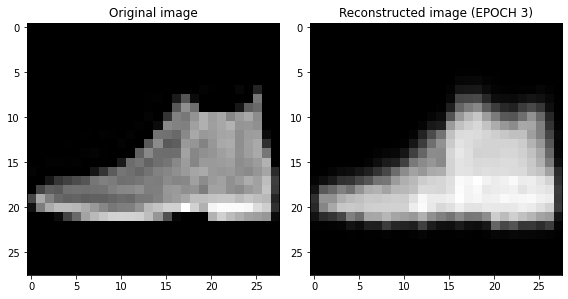

EPOCH 4/9


	 VALIDATION - EPOCH 4/9 - loss: 0.017560




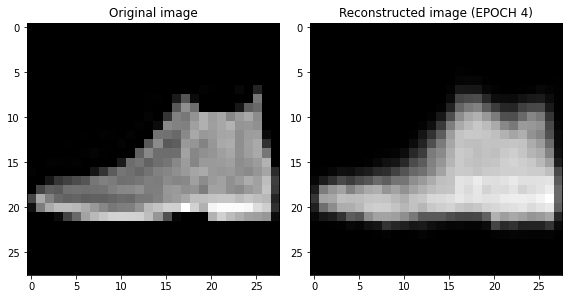

EPOCH 5/9


	 VALIDATION - EPOCH 5/9 - loss: 0.016422




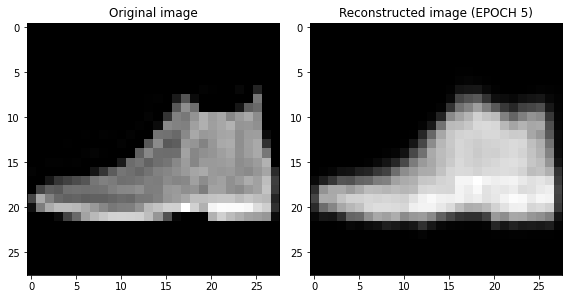

EPOCH 6/9


	 VALIDATION - EPOCH 6/9 - loss: 0.015949




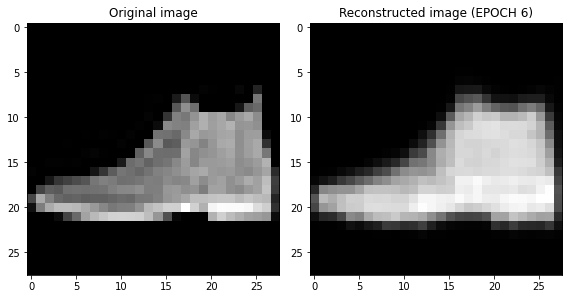

EPOCH 7/9


	 VALIDATION - EPOCH 7/9 - loss: 0.015420




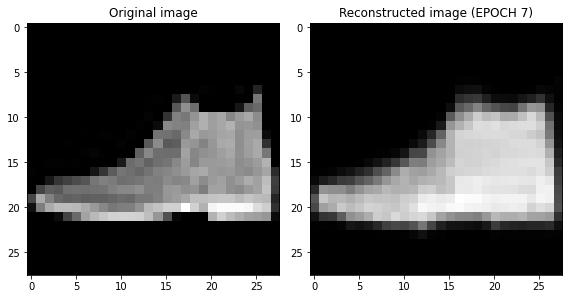

EPOCH 8/9


	 VALIDATION - EPOCH 8/9 - loss: 0.015272




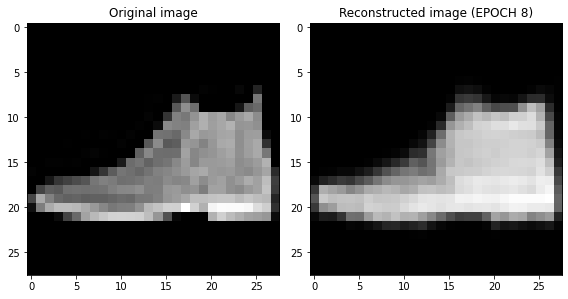

EPOCH 9/9


	 VALIDATION - EPOCH 9/9 - loss: 0.015688




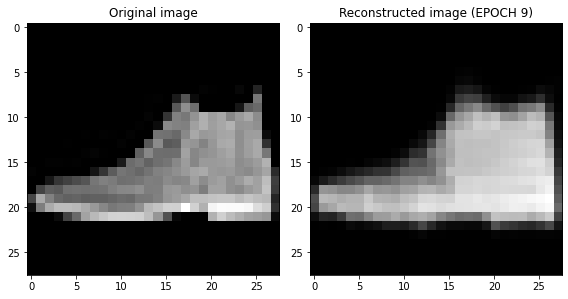

In [63]:
torch.manual_seed(0)
encoded_space_dim = 10
bestParams = {'lr': 0.004748478691420016, 'optimizer': 'Adam', 'NumF1': 12.0, 'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}

ModelAE10 = AE3class(encoded_space_dim=encoded_space_dim,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))


### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = ModelAE10.parameters()
optim = torch.optim.Adam(params_to_optimize, lr=bestParams['lr'])

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
ModelAE10.to(device)
### Training cycle
epochs = 10
trainErrorADAM,valErrorADAM,finalErrADAM = trainingLoop(Epoch=epoch,Model=ModelAE10,
                                                        trainL=train_dataloader,
                                                        validL=validation_dataloader,
                                                        LossFun=loss_fn,Optimizer=optim,
                                                        plotEachEpoch=True)


### test error of trained model

In [68]:
testError,_ = test_epoch(ModelAE10,device,test_dataloader,loss_fn)
print("------------------- Test error of trained AE with latent space of size 10 -------------------")
print(testError)

------------------- Test error of trained AE with latent space of size 10 -------------------
tensor(0.0156)


In [69]:
### Get the encoded representation of the test samples
torch.manual_seed(0)
encoded_space_dim = 10
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    ModelAE10.eval()
    with torch.no_grad():
        _,encoded_img  = ModelAE10(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:19<00:00, 500.78it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,label
0,10.926778,-1.919093,24.256931,14.978956,-0.104796,-27.011944,-9.630500,0.919613,-0.204294,6.128501,9
1,9.399822,19.640608,-3.605259,-2.436935,-9.947672,4.108913,-0.220054,-14.354471,-8.889922,-11.443565,2
2,-20.685661,-27.675022,0.758675,-24.712662,-13.369434,-5.238055,2.393812,-5.927077,-21.606798,-12.482320,1
3,-9.372653,-34.005775,1.613868,-18.929605,-4.012791,-9.184009,6.209491,-3.394056,-8.078846,-8.872626,1
4,9.646868,7.913572,0.817533,-8.314522,-4.679872,-5.816954,5.155090,1.673804,1.210674,-6.766289,6
...,...,...,...,...,...,...,...,...,...,...,...
9995,16.958334,9.897820,8.415632,13.898117,-1.494473,-18.335045,-18.381191,6.412524,-8.822233,4.113956,9
9996,-2.696543,-31.553755,7.779823,-17.606110,-0.559203,-11.590526,13.024510,-0.040303,-1.973434,-9.802259,1
9997,-1.111291,-9.467403,3.715070,-22.780834,-2.387790,-24.083548,-6.050921,-4.936795,9.841243,-22.783573,8
9998,-28.077362,-42.978027,3.015672,-16.749880,-5.065055,-16.067474,11.103615,5.544601,-12.385127,-9.034846,1


**How can we visualize data?** we like 2D-3D plots for intuition!

PCA and tSNE come into play.

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
# encoded_samples_reduced_PCA

In [73]:
Encoded_samples = pd.DataFrame(encoded_samples_reduced_PCA)
# Encoded_samples

In [74]:
px.scatter(Encoded_samples,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

In [75]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
Encoded_samples_tsne = pd.DataFrame(encoded_samples_reduced_TSNE)
Encoded_samples_tsne
# plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



,0,1
0,-58.788815,-20.669207
1,7.570549,68.174500
2,5.824970,-76.934090
3,15.715141,-62.389610
4,-9.498906,33.260471
...,...,...
9995,-80.621651,-6.458845
9996,25.371681,-57.817085
9997,-19.377474,-3.729570
9998,26.228285,-77.690750


In [76]:
px.scatter(Encoded_samples_tsne,x=0, y=1,
           color=[label_names[l] for l in encoded_samples.label.to_numpy()],
           opacity=0.7)

Given a point cloud:
*   **PCA** is like taking a snapshot from a different perspective/angle (linear only)
*   **tSNE** is like taking a snapshot from a different perspective/angle and at the same time stretching the space (non-linear)
